In [23]:
# import necessary library
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [24]:
data = pd.read_excel('LoadProfile/dt13151011.xls')

In [48]:
load_sample = data.iloc[3:98, 3]
# load_sample = load_sample/np.max(load_sample)

energy_sample = np.sum(load_sample)/4

# load data scale energy equal to 1, so that if we have energy data we can sample this load profile
load_scale_energy = load_sample/energy_sample 

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


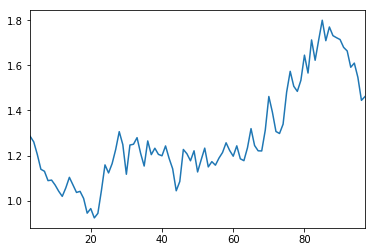

In [186]:
scale = 0.6/1.4760870897413207
load_test = load_scale_energy*scale*300
load_test.plot()
load_test = np.concatenate((load_test.reshape(95,1), np.array(load_test.iloc[-1]).reshape(1,1)))

# import pv data

In [85]:
pv = pd.read_excel('SolarRadiance/2013-12-22.xls')
pv_power = pv.iloc[5:, 16]/1000
pv_power= pv_power.fillna(0)

In [86]:
pv_power.shape

(288,)

In [87]:
# convert pv data every 5 min to every 15 min
count = 0
pv_15 = []

for i in range(pv_power.shape[0]):
    
    count += 1
    if count ==3:
        avg = np.sum(pv_power[i-2:i+1])/3
        pv_15.append(avg)
        count = 0

len(pv_15)

96

In [89]:
pv_power_scale = pv_15/np.max(pv_15)

In [90]:
off_peak_rate = 2.6296
on_peak_rate = 4.3555

tou = []
for i in range(96):
    
    if i <=36 or i >36+52:
        tou.append(off_peak_rate)
    else:
        tou.append(on_peak_rate)
        

In [220]:
## PV cost and BESS cost
cost_norm_inverter = 11.8*1000  # Baht/W
cost_norm_pv = 37.5*1000        # Baht/W

cost_pv = (cost_norm_inverter + cost_norm_pv)
cost_pv = cost_pv*5

bess_cost_kWh = 300*35
bess_cost_kW = (0.71 + 0.21 + 0.57 + 0.15 + 0.75 + 0.06)*35*1000

bess_cost_kWh = bess_cost_kWh/3
bess_cost_kW = bess_cost_kW/3

In [221]:
## Optimization formulation

# NPV factor
year = 25
r = 5
discount = (1 - (1/(1 + r/100))**year)/(1-(1/(1 + r/100)))

# coefficient of PV size
c = -np.dot(pv_power_scale, tou)
c = 365*c*discount + cost_pv
c = [c]

# coefficient of BESS energy
c.append(bess_cost_kWh)

# coefficient of BESS kW
c.append(bess_cost_kW)

# coefficient of BESS charge and discharge and TOU
c.extend(list(np.array(tou)*365*discount/4))

In [229]:
soc = 0.7
len_time = len(pv_15)
Crate = 2

A = np.array([[-3, 1], [1, 2]])

# Pl - Ppv - Pbess >= 0
A_1 = np.array(pv_power_scale).reshape(96,1)
A_1 = np.concatenate((A_1, np.zeros((len_time,1))),axis = 1)
A_1 = np.concatenate((A_1, np.zeros((len_time,1))),axis = 1)
A_1 = np.concatenate((A_1, np.identity(len_time)),axis = 1)

# SOC <= 90
A_2 = np.zeros((len_time,1))
A_2 = np.concatenate((A_2, (soc-0.9)*np.ones((len_time,1))),axis = 1)
A_2 = np.concatenate((A_2, np.zeros((len_time,1))),axis = 1)
A_2 = np.concatenate((A_2, np.tril(np.ones((len_time)))),axis = 1)
# SOC >= 10
A_3 = np.zeros((len_time,1))
A_3 = np.concatenate((A_3, (-soc+0.1)*np.ones((len_time,1))),axis = 1)
A_3 = np.concatenate((A_3, np.zeros((len_time,1))),axis = 1)
A_3 = np.concatenate((A_3, -np.tril(np.ones((len_time)))),axis = 1)
# Pbess(t) <= Prate for all t
A_4 = np.zeros((len_time,1))
A_4 = np.concatenate((A_4, np.zeros((len_time,1))), axis=1)
A_4 = np.concatenate((A_4, -np.ones((len_time,1))), axis=1)
A_4 = np.concatenate((A_4, np.identity(len_time)), axis=1)
# Pbess(t) >= -Prate for all t
A_5 = np.zeros((len_time,1))
A_5 = np.concatenate((A_5, np.zeros((len_time,1))), axis=1)
A_5 = np.concatenate((A_5, -np.ones((len_time,1))), axis=1)
A_5 = np.concatenate((A_5, -np.identity(len_time)), axis=1)
# sum(Pbess(t)) = 0 
A_6 = np.array([0,0,0]).reshape(3,1)
A_6 = np.concatenate((A_6, -np.ones((len_time,1))), axis = 0)
A_6 = A_6.T
#  Crate <= 2
A_7 = np.array([0, -Crate, 1]).reshape(3,1)
A_7 = np.concatenate((A_7, np.zeros((len_time,1))))
A_7 = A_7.T

A = np.concatenate((A_1,A_2,A_3,A_4,A_5,A_6,A_7),axis=0)

b = load_test.reshape(96,1)
b = np.concatenate((b, np.zeros((len_time*4,1))))
b = np.concatenate((b,np.array(0).reshape(1,1)))
b = np.concatenate((b,np.array(2).reshape(1,1)))

lb = np.array([[0, 0, 0], [10000, 10000, 10000]]).reshape(3,2)

for i in range(96):
    lb = np.concatenate((lb, np.array([-10000, 10000]).reshape(1,2)))

In [230]:
res = linprog(c, A_ub=list(A), b_ub=list(b), bounds=lb)